In [1]:
%load_ext autoreload

In [2]:
import lightning.pytorch as pl
import torch
import pandas as pd
import os
import scanpy as sc
import seaborn as sns
import anndata
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [3]:
%autoreload 2
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from self_supervision.tester.reconstruction.test import test_pretrained_model
from self_supervision.paths import DATA_DIR, TRAINING_FOLDER, RESULTS_FOLDER

In [4]:
STORE_DIR = os.path.join(DATA_DIR, 'merlin_cxg_2023_05_15_sf-log1p')

In [5]:
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Set the colorblind friendly palette
sns.set_theme(style="whitegrid")

sns.set_palette("colorblind")

# Get the list of colors in the palette
palette_colors = sns.color_palette("colorblind")

# Access the colors
color_supervised = palette_colors[0]  # First color
color_ssl = palette_colors[1]  # Second color
color_zeroshot = palette_colors[2]  # Third color
color_baseline = palette_colors[3]  # Forth color, ([3] looks similar to [0])
color_else1 = palette_colors[5]
color_else2 = palette_colors[6]
color_else3 = palette_colors[7]

# Load Results

In [6]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)

df

experiment  \
5                                              CN_MLP_50p   
6                                          CN_MLP_50prun1   
7                                          CN_MLP_50prun2   
8                                          CN_MLP_50prun3   
9                                          CN_MLP_50prun4   
10                             CN_MLP_gene_program_C8_25p   
12                                        CN_MLP_gp_to_tf   
13                                    CN_MLP_gp_to_tfrun1   
14                                    CN_MLP_gp_to_tfrun2   
15                                    CN_MLP_gp_to_tfrun3   
16                                    CN_MLP_gp_to_tfrun4   
11                             CN_MLP_single_gene_program   
37                                      CN_NegBin_50prun0   
49                                      CN_NegBin_50prun1   
50                                      CN_NegBin_50prun2   
51                                      CN_NegBin_50prun3   
52                                      CN_NegBin_50prun4   
39                                 CN_NegBin_gp_to_tfrun0   
40                                 CN_NegBin_gp_to_tfrun1   
41                                 CN_NegBin_gp_to_tfrun2   
42                                 CN_NegBin_gp_to_tfrun3   
43                                 CN_NegBin_gp_to_tfrun4   
53                      CN_NegBin_single_gene_programrun0   
0                                    CN_No_SSL_CN_MLPrun0   
1                                    CN_No_SSL_CN_MLPrun1   
2                                    CN_No_SSL_CN_MLPrun2   
3                                    CN_No_SSL_CN_MLPrun3   
4                                    CN_No_SSL_CN_MLPrun4   
32                               CN_No_SSL_CN_run0NegBin_   
33                               CN_No_SSL_CN_run1NegBin_   
34                               CN_No_SSL_CN_run2NegBin_   
35                               CN_No_SSL_CN_run3NegBin_   
36                               CN_No_SSL_CN_run4NegBin_   
17                               CN_SSL_CN_CN_MLP_50prun0   
54                        CN_SSL_CN_CN_MLP_50prun0NegBin_   
18                               CN_SSL_CN_CN_MLP_50prun1   
19                               CN_SSL_CN_CN_MLP_50prun2   
20                               CN_SSL_CN_CN_MLP_50prun3   
21                               CN_SSL_CN_CN_MLP_50prun4   
23               CN_SSL_CN_CN_MLP_gene_program_C8_25prun0   
55        CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_   
22               CN_SSL_CN_CN_MLP_gene_program_C8_50prun0   
25                          CN_SSL_CN_CN_MLP_gp_to_tfrun0   
26                          CN_SSL_CN_CN_MLP_gp_to_tfrun1   
27                          CN_SSL_CN_CN_MLP_gp_to_tfrun2   
28                          CN_SSL_CN_CN_MLP_gp_to_tfrun3   
29                          CN_SSL_CN_CN_MLP_gp_to_tfrun4   
24               CN_SSL_CN_CN_MLP_single_gene_programrun0   
56        CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_   
44            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_   
45            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_   
46            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_   
47            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_   
48            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_   
57        CN_SSL_CN_MLP_BYOL_Gaussian_0_001_v4run0NegBin_   
30                  CN_SSL_CN_MLP_BYOL_Gaussian_0_001run0   
31         CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0   
58  CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0NegBin_   
38                                                 Random   

    Explained Variance Uniform  Explained Variance Weighted       MSE  
5                     0.155226                     0.252466  0.139534  
6                     0.152973                     0.251865  0.139680  
7                     0.152813                     0.251179  0.139711  
8                     0.152603                     0.250942  0.139777  
9                     0.15

In [7]:
models_to_select = [
                    ### Only pretrained models ###
    
                    # Random Mask
                    'CN_NegBin_50prun0',  # Median Run
                    # Gene Program Masek
                    # TO DO
                    # GP to GP
                    'CN_NegBin_single_gene_programrun0',
                    # GP to TF
                    'CN_NegBin_gp_to_tfrun3',  # Median Run
    
                    ### Supervised model ###
    
                    'CN_No_SSL_CN_run1NegBin_',  # Median Run
    
                    ### Self-Supervised models ###
    
                    # Random Mask
                    'CN_SSL_CN_CN_MLP_50prun0NegBin_',
                    # Gene Program Mask
                    'CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_',
                    # GP to GP
                    'CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_',
                    # GP to TF
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',  # Median run
                    # BYOL
                    # TO DO
                    # Barlow Twins
                    # TO DO
    
                    ### Random ###
                    # 'Random',
                   ]

df = df[df['experiment'].isin(models_to_select)]
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
df

experiment  \
37                                CN_NegBin_50prun0   
42                           CN_NegBin_gp_to_tfrun3   
53                CN_NegBin_single_gene_programrun0   
33                         CN_No_SSL_CN_run1NegBin_   
54                  CN_SSL_CN_CN_MLP_50prun0NegBin_   
55  CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_   
56  CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_   
48      CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_   

    Explained Variance Uniform  Explained Variance Weighted       MSE  
37                    0.166044                     0.366818  0.102326  
42                    0.188583                     0.383413  0.099498  
53                    0.187824                     0.383398  0.099499  
33                    0.180600                     0.378120  0.100453  
54                    0.180959                     0.377217  0.100699  
55                    0.178291                     0.377176  0.100627  
56                    0.182529                     0.377372  0.100606  
48                    0.180490                     0.379778  0.100167

In [9]:
custom_model_names = {
    'CN_NegBin_50prun0': 'Zero-Shot\nRandom Mask',
    # 'CN_MLP_gene_program_C8_25p': 'Zero-Shot\nGP Mask',
    'CN_NegBin_gp_to_tfrun3': 'Zero-Shot\nGP to TF',
    'CN_NegBin_single_gene_programrun0': 'Zero-Shot\nGP to GP',
    'CN_No_SSL_CN_run1NegBin_': 'Supervised',
    'CN_SSL_CN_CN_MLP_50prun0NegBin_': 'Self-Supervised\nRandom Mask',
    'CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_': 'Self-Supervised\nGP Mask',
    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_': 'Self-Supervised\nGP to TF',
    'CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_': 'Self-Supervised\nGP to GP',
    # 'CN_SSL_CN_MLP_BYOL_Gaussian_0_001run0': 'Self-Supervised\nBYOL',
    # 'CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0': 'Self-Supervised\nBarlow Twins',
}

df['experiment'] = df['experiment'].apply(lambda x: custom_model_names.get(x, x))
df

experiment  Explained Variance Uniform  \
37        Zero-Shot\nRandom Mask                    0.166044   
42           Zero-Shot\nGP to TF                    0.188583   
53           Zero-Shot\nGP to GP                    0.187824   
33                    Supervised                    0.180600   
54  Self-Supervised\nRandom Mask                    0.180959   
55      Self-Supervised\nGP Mask                    0.178291   
56     Self-Supervised\nGP to GP                    0.182529   
48     Self-Supervised\nGP to TF                    0.180490   

    Explained Variance Weighted       MSE  
37                     0.366818  0.102326  
42                     0.383413  0.099498  
53                     0.383398  0.099499  
33                     0.378120  0.100453  
54                     0.377217  0.100699  
55                     0.377176  0.100627  
56                     0.377372  0.100606  
48                     0.379778  0.100167

In [10]:
# Remove the outliers
outliers = ['Zero-Shot\nGP Mask']
df = df[~df['experiment'].isin(outliers)]
df

experiment  Explained Variance Uniform  \
37        Zero-Shot\nRandom Mask                    0.166044   
42           Zero-Shot\nGP to TF                    0.188583   
53           Zero-Shot\nGP to GP                    0.187824   
33                    Supervised                    0.180600   
54  Self-Supervised\nRandom Mask                    0.180959   
55      Self-Supervised\nGP Mask                    0.178291   
56     Self-Supervised\nGP to GP                    0.182529   
48     Self-Supervised\nGP to TF                    0.180490   

    Explained Variance Weighted       MSE  
37                     0.366818  0.102326  
42                     0.383413  0.099498  
53                     0.383398  0.099499  
33                     0.378120  0.100453  
54                     0.377217  0.100699  
55                     0.377176  0.100627  
56                     0.377372  0.100606  
48                     0.379778  0.100167

In [11]:
color_dict = {
    'Supervised': color_supervised,
    'Self-Supervised\nRandom Mask': color_ssl,
    'Self-Supervised\nGP Mask': color_ssl,
    'Self-Supervised\nGP to TF': color_ssl,
    'Self-Supervised\nGP to GP': color_ssl,
    'Self-Supervised\nBYOL': color_ssl,
    'Self-Supervised\nBarlow Twins': color_ssl,
    'Zero-Shot\nRandom Mask': color_zeroshot,
    'Zero-Shot\nGP to TF': color_zeroshot,
    'Zero-Shot\nGP to GP': color_zeroshot,
    # Add other Zero-Shot types if present
}


### Figure 1 - Model Comparison all models with barplots

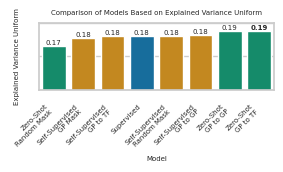

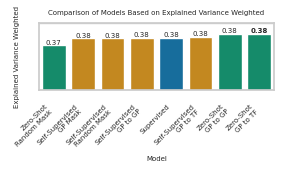

In [12]:
# Map the model types to specific colors
df['Color'] = df['experiment'].map(color_dict)
assert not df['Color'].isnull().any(), "Some model types don't have a color assigned in the color_dict."

# Sort the dataframe for the plots
df_sorted_uniform = df.sort_values('Explained Variance Uniform')
df_sorted_weighted = df.sort_values('Explained Variance Weighted')

# Adjusted function to annotate bars
def annotate_bars(ax, data, score_column):
    max_height = data[score_column].max()
    for p in ax.patches:
        annotation = f"{p.get_height():.2f}"
        weight = 'bold' if p.get_height() == max_height else 'normal'
        ax.annotate(annotation, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=5, weight=weight)

# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 1.75))
ax1 = sns.barplot(x='experiment', y='Explained Variance Uniform', data=df_sorted_uniform,
                  palette=df_sorted_uniform['Color'].tolist())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=5)
ax1.set_yticklabels([])
ax1.set_xlabel('Model', fontsize=5)
ax1.set_ylim((0.1, 0.2))
ax1.set_ylabel('Explained Variance Uniform', fontsize=5)
annotate_bars(ax1, df_sorted_uniform, 'Explained Variance Uniform')
plt.tight_layout()
ax1.set_title('Comparison of Models Based on Explained Variance Uniform', fontsize=5)
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_Model_Comparison_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 1.75))
ax2 = sns.barplot(x='experiment', y='Explained Variance Weighted', data=df_sorted_weighted,
                  palette=df_sorted_weighted['Color'].tolist())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=5)
ax2.set_yticklabels([])
ax2.set_xlabel('Model', fontsize=5)
ax2.set_ylim((0.3, 0.4))
ax2.set_ylabel('Explained Variance Weighted', fontsize=5)
annotate_bars(ax2, df_sorted_weighted, 'Explained Variance Weighted')
plt.tight_layout()
ax2.set_title('Comparison of Models Based on Explained Variance Weighted', fontsize=5)
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_Model_Comparison_EV_Weighted.svg", bbox_inches='tight')
plt.show()


### Figure 2: Model comparison with box-plots

In [13]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report.csv')
pd.set_option('display.max_colwidth', 1000)
df = pd.read_csv(file_path)

df = df.sort_values(by='experiment', ascending=True)

# Filter out unwanted experiments
df = df[df['experiment'].str.contains('NegBin')]

# Split the experiment into 'Model' and 'Run'
df['Model'] = df['experiment'].apply(lambda x: ' '.join(x.split('_')[:-1]))

# Include the experiment labeled 'NaN'
df.loc[df['experiment'].isnull(), 'experiment'] = 'MLP_bt_Gaussian_0_001_run0'

# Now the DataFrame is ready for boxplot visualization
df.head()  # Display the first few rows to verify the data

df

experiment  \
37                                      CN_NegBin_50prun0   
49                                      CN_NegBin_50prun1   
50                                      CN_NegBin_50prun2   
51                                      CN_NegBin_50prun3   
52                                      CN_NegBin_50prun4   
39                                 CN_NegBin_gp_to_tfrun0   
40                                 CN_NegBin_gp_to_tfrun1   
41                                 CN_NegBin_gp_to_tfrun2   
42                                 CN_NegBin_gp_to_tfrun3   
43                                 CN_NegBin_gp_to_tfrun4   
53                      CN_NegBin_single_gene_programrun0   
32                               CN_No_SSL_CN_run0NegBin_   
33                               CN_No_SSL_CN_run1NegBin_   
34                               CN_No_SSL_CN_run2NegBin_   
35                               CN_No_SSL_CN_run3NegBin_   
36                               CN_No_SSL_CN_run4NegBin_   
54                        CN_SSL_CN_CN_MLP_50prun0NegBin_   
55        CN_SSL_CN_CN_MLP_gene_program_C8_25prun0NegBin_   
56        CN_SSL_CN_CN_MLP_single_gene_programrun0NegBin_   
44            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_   
45            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_   
46            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_   
47            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_   
48            CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_   
57        CN_SSL_CN_MLP_BYOL_Gaussian_0_001_v4run0NegBin_   
58  CN_SSL_CN_contrastive_MLP_bt_Gaussian_0_01run0NegBin_   

    Explained Variance Uniform  Explained Variance Weighted       MSE  \
37                    0.166044                     0.366818  0.102326   
49                    0.166076                     0.367275  0.102223   
50                    0.157059                     0.366830  0.102297   
51                    0.163737                     0.366949  0.102262   
52                    0.164499                     0.366672  0.102324   
39                    0.187810                     0.383466  0.099487   
40                    0.187587                     0.383286  0.099528   
41                    0.185744                     0.383344  0.099517   
42                    0.188583                     0.383413  0.099498   
43                    0.188651                     0.383535  0.099481   
53                    0.187824                     0.383398  0.099499   
32                    0.178914                     0.378889  0.100295   
33                    0.180600                     0.378120  0.100453   
34                    0.176232                     0.378180  0.100393   
35                    0.176843                     0.377674  0.100521   
36                    0.176809                     0.377811  0.100471   
54                    0.180959                     0.377217  0.100699   
55                    0.178291                     0.377176  0.100627   
56                    0.182529                     0.377372  0.100606   
44                    0.178942                     0.379748  0.100161   
45                    0.180614                     0.379808  0.100155   
46                    0.181215                     0.379773  0.100178   
47                    0.181800                     0.379769  0.100164   
48                    0.180490                     0.379778  0.100167   
57                    0.178515                     0.378653  0.100325   
58                    0.180734                     0.379237  0.100229   

                                                   Model  
37                                             CN NegBin  
49                                             CN NegBin  
50                                             CN NegBin  
51                                             CN NegBin  
52                                             CN NegBin  
39                                       CN NegBin gp to  
40            

In [14]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                   ]

df_subset = df[df['experiment'].isin(models_to_select)]
df_subset

experiment  Explained Variance Uniform  \
39                       CN_NegBin_gp_to_tfrun0                    0.187810   
40                       CN_NegBin_gp_to_tfrun1                    0.187587   
41                       CN_NegBin_gp_to_tfrun2                    0.185744   
42                       CN_NegBin_gp_to_tfrun3                    0.188583   
43                       CN_NegBin_gp_to_tfrun4                    0.188651   
32                     CN_No_SSL_CN_run0NegBin_                    0.178914   
33                     CN_No_SSL_CN_run1NegBin_                    0.180600   
34                     CN_No_SSL_CN_run2NegBin_                    0.176232   
35                     CN_No_SSL_CN_run3NegBin_                    0.176843   
36                     CN_No_SSL_CN_run4NegBin_                    0.176809   
44  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.178942   
45  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.180614   
46  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.181215   
47  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.181800   
48  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.180490   

    Explained Variance Weighted       MSE  \
39                     0.383466  0.099487   
40                     0.383286  0.099528   
41                     0.383344  0.099517   
42                     0.383413  0.099498   
43                     0.383535  0.099481   
32                     0.378889  0.100295   
33                     0.378120  0.100453   
34                     0.378180  0.100393   
35                     0.377674  0.100521   
36                     0.377811  0.100471   
44                     0.379748  0.100161   
45                     0.379808  0.100155   
46                     0.379773  0.100178   
47                     0.379769  0.100164   
48                     0.379778  0.100167   

                                         Model  
39                             CN NegBin gp to  
40                             CN NegBin gp to  
41                             CN NegBin gp to  
42                             CN NegBin gp to  
43                             CN NegBin gp to  
32                     CN No SSL CN run0NegBin  
33                     CN No SSL CN run1NegBin  
34                     CN No SSL CN run2NegBin  
35                     CN No SSL CN run3NegBin  
36                     CN No SSL CN run4NegBin  
44  CN SSL CN CN NegBin gp to tfrun0run0NegBin  
45  CN SSL CN CN NegBin gp to tfrun0run1NegBin  
46  CN SSL CN CN NegBin gp to tfrun0run2NegBin  
47  CN SSL CN CN NegBin gp to tfrun0run3NegBin  
48  CN SSL CN CN NegBin gp to tfrun0run4NegBin

In [15]:

def extract_model_type(row):
    if 'SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised\nGP to TF'
    elif 'No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot\nGP to TF'
    else:
        return 'Unknown'

# Apply the function to the dataframe
df_subset['Model'] = df_subset.apply(extract_model_type, axis=1)
df_subset

experiment  Explained Variance Uniform  \
39                       CN_NegBin_gp_to_tfrun0                    0.187810   
40                       CN_NegBin_gp_to_tfrun1                    0.187587   
41                       CN_NegBin_gp_to_tfrun2                    0.185744   
42                       CN_NegBin_gp_to_tfrun3                    0.188583   
43                       CN_NegBin_gp_to_tfrun4                    0.188651   
32                     CN_No_SSL_CN_run0NegBin_                    0.178914   
33                     CN_No_SSL_CN_run1NegBin_                    0.180600   
34                     CN_No_SSL_CN_run2NegBin_                    0.176232   
35                     CN_No_SSL_CN_run3NegBin_                    0.176843   
36                     CN_No_SSL_CN_run4NegBin_                    0.176809   
44  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.178942   
45  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.180614   
46  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.181215   
47  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.181800   
48  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.180490   

    Explained Variance Weighted       MSE                      Model  
39                     0.383466  0.099487        Zero-Shot\nGP to TF  
40                     0.383286  0.099528        Zero-Shot\nGP to TF  
41                     0.383344  0.099517        Zero-Shot\nGP to TF  
42                     0.383413  0.099498        Zero-Shot\nGP to TF  
43                     0.383535  0.099481        Zero-Shot\nGP to TF  
32                     0.378889  0.100295                 Supervised  
33                     0.378120  0.100453                 Supervised  
34                     0.378180  0.100393                 Supervised  
35                     0.377674  0.100521                 Supervised  
36                     0.377811  0.100471                 Supervised  
44                     0.379748  0.100161  Self-Supervised\nGP to TF  
45                     0.379808  0.100155  Self-Supervised\nGP to TF  
46                     0.379773  0.100178  Self-Supervised\nGP to TF  
47                     0.379769  0.100164  Self-Supervised\nGP to TF  
48                     0.379778  0.100167  Self-Supervised\nGP to TF

<Figure size 300x200 with 0 Axes>

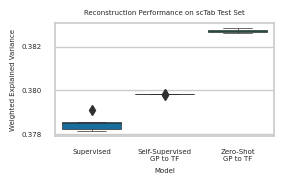

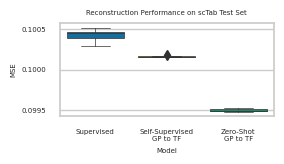

<Figure size 640x480 with 0 Axes>

In [16]:
# Define the order of models
model_order = ["Supervised", "Self-Supervised\nGP to TF", "Zero-Shot\nGP to TF"]

# Define color mapping for each model type
model_colors = {
    "Supervised": color_supervised,
    "Self-Supervised\nGP to TF": color_ssl,
    "Zero-Shot\nGP to TF": color_zeroshot,
}

# Debugging: Print median values before plotting
# print(df_subset.groupby('Model')['f1-score: macro avg'].median())

# Plot for Macro F1 Score with individual points
plt.figure(figsize=(3, 2))
# Plot for Macro F1 Score with individual points
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Model', y='Explained Variance Weighted', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Weighted Explained Variance', fontdict=font)
ax1.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(3, 1.8))
ax2 = sns.boxplot(x='Model', y='MSE', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('MSE', fontdict=font)
ax2.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


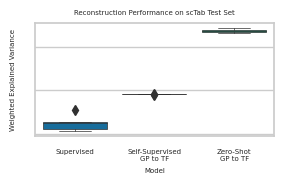

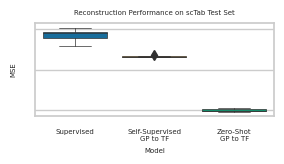

In [17]:
# Define the order of models
model_order = ["Supervised", "Self-Supervised\nGP to TF", "Zero-Shot\nGP to TF"]

# Define color mapping for each model type
model_colors = {
    "Supervised": color_supervised,
    "Self-Supervised\nGP to TF": color_ssl,
    "Zero-Shot\nGP to TF": color_zeroshot,
}

# Debugging: Print median values before plotting
# print(df_subset.groupby('Model')['f1-score: macro avg'].median())

# Plot for Macro F1 Score with individual points
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Model', y='Explained Variance Weighted', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels([])
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Weighted Explained Variance', fontdict=font)
ax1.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_Model_Comparison_Weighted_EV_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(3, 1.8))
ax2 = sns.boxplot(x='Model', y='MSE', data=df_subset, linewidth=0.5, order=model_order, palette=model_colors)
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels([])
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('MSE', fontdict=font)
ax2.set_title('Reconstruction Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_Model_Comparison_MSE_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()


# Fig 3: OOD Reconstruction

**Dissection: Tail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC**

- 56,367 cells
- 10x 3' v3
- hippocampal formation
- astrocyte (3761), central nervous system macrophage (1782), endothelial cell (174), ependymal cell (111), ~~fibroblast (86)~~, leukocyte (36), neuron (36588), oligodendrocyte (11875), oligodendrocyte precursor cell (1896), pericyte (39), vascular associated smooth muscle cell (19)

In [18]:
ood_set = 'tail_of_hippocampus'

In [19]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)

df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale
# Show the first few rows to get an overview of the data
df

experiment  Explained Variance Uniform  \
4                               CN_MLP_gp_to_tf                    0.016797   
7                           CN_MLP_gp_to_tfrun1                    0.016014   
8                           CN_MLP_gp_to_tfrun2                    0.016815   
9                           CN_MLP_gp_to_tfrun3                    0.016650   
10                          CN_MLP_gp_to_tfrun4                    0.016509   
21                       CN_NegBin_gp_to_tfrun0                    0.023352   
22                       CN_NegBin_gp_to_tfrun1                    0.023128   
23                       CN_NegBin_gp_to_tfrun2                    0.023136   
24                       CN_NegBin_gp_to_tfrun3                    0.023033   
25                       CN_NegBin_gp_to_tfrun4                    0.023282   
0                          CN_No_SSL_CN_MLPrun0                    0.016358   
1                          CN_No_SSL_CN_MLPrun1                    0.015945   
2                          CN_No_SSL_CN_MLPrun2                    0.015872   
3                          CN_No_SSL_CN_MLPrun3                    0.016056   
6                          CN_No_SSL_CN_MLPrun4                    0.015622   
16                     CN_No_SSL_CN_run0NegBin_                    0.021411   
17                     CN_No_SSL_CN_run1NegBin_                    0.021023   
18                     CN_No_SSL_CN_run2NegBin_                    0.021274   
19                     CN_No_SSL_CN_run3NegBin_                    0.021309   
20                     CN_No_SSL_CN_run4NegBin_                    0.021053   
5                 CN_SSL_CN_CN_MLP_gp_to_tfrun0                    0.016443   
11                CN_SSL_CN_CN_MLP_gp_to_tfrun1                    0.015756   
12                CN_SSL_CN_CN_MLP_gp_to_tfrun2                    0.015950   
13                CN_SSL_CN_CN_MLP_gp_to_tfrun3                    0.014151   
14                CN_SSL_CN_CN_MLP_gp_to_tfrun4                    0.015975   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.021920   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.021945   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.022006   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.022022   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.021926   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
4                      0.054392  0.135386  
7                      0.054289  0.135240  
8                      0.054107  0.135342  
9                      0.053559  0.135497  
10                     0.053556  0.135474  
21                     0.077961  0.103577  
22                     0.077546  0.103651  
23                     0.077902  0.103598  
24                     0.077681  0.103649  
25                     0.077862  0.103494  
0                      0.051173  0.135936  
1                      0.051081  0.136072  
2                      0.050801  0.136020  
3                      0.050569  0.136130  
6                      0.050514  0.136189  
16                     0.073359  0.104621  
17                     0.072452  0.104728  
18                     0.072865  0.104778  
19                     0.072595  0.104942  
20                     0.072447  0.104825  
5                      0.052418  0.135965  
11                     0.049948  0.136301  
12                     0.052088  0.136061  
13                     0.050460  0.136389  
14                     0.051896  0.136062  
26                     0.074122  0.104593  
27                     0.074107  0.104624  
28                     0.074167  0.104646  
29                     0.074056  0.104603  
30                     0.074061  0.104689  
15                     0.000000  0.340121

In [20]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  Explained Variance Uniform  \
21                       CN_NegBin_gp_to_tfrun0                    0.023352   
22                       CN_NegBin_gp_to_tfrun1                    0.023128   
23                       CN_NegBin_gp_to_tfrun2                    0.023136   
24                       CN_NegBin_gp_to_tfrun3                    0.023033   
25                       CN_NegBin_gp_to_tfrun4                    0.023282   
16                     CN_No_SSL_CN_run0NegBin_                    0.021411   
17                     CN_No_SSL_CN_run1NegBin_                    0.021023   
18                     CN_No_SSL_CN_run2NegBin_                    0.021274   
19                     CN_No_SSL_CN_run3NegBin_                    0.021309   
20                     CN_No_SSL_CN_run4NegBin_                    0.021053   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.021920   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.021945   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.022006   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.022022   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.021926   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
21                     0.077961  0.103577  
22                     0.077546  0.103651  
23                     0.077902  0.103598  
24                     0.077681  0.103649  
25                     0.077862  0.103494  
16                     0.073359  0.104621  
17                     0.072452  0.104728  
18                     0.072865  0.104778  
19                     0.072595  0.104942  
20                     0.072447  0.104825  
26                     0.074122  0.104593  
27                     0.074107  0.104624  
28                     0.074167  0.104646  
29                     0.074056  0.104603  
30                     0.074061  0.104689  
15                     0.000000  0.340121

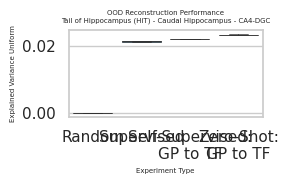

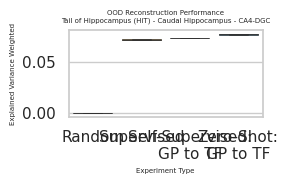

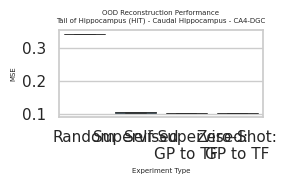

In [21]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors1 = [color_supervised, color_ssl, color_zeroshot]
model_colors2 = [color_ssl, color_supervised, color_zeroshot]

# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors2)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)


plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_HiT_EV_Uniforma.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors1)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_HiT_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors2)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_HiT_MSE.svg", bbox_inches='tight')
plt.show()

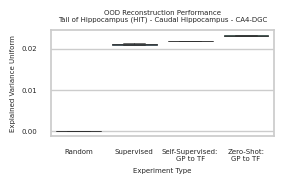

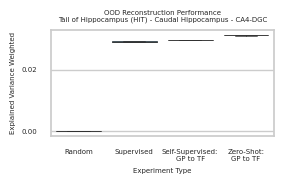

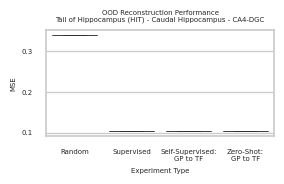

In [22]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors1 = [color_baseline, color_supervised, color_ssl, color_zeroshot]

# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors1)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)


plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_HiT_EV_Uniforma.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors1)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_HiT_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors1)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_HiT_MSE.svg", bbox_inches='tight')
plt.show()

**All non-neuronal cells**

- 888,263 cells
- 10x 3' v3
- Bergmann glial cell (8041), astrocyte (155025), central nervous system macrophage (91383), ~~choroid plexus epithelial cell (7689)~~, endothelial cell (5165), ependymal cell (5882), ~~fibroblast (9156)~~, oligodendrocyte (494966), oligodendrocyte precursor cell (105734), pericyte (3693), vascular associated smooth muscle cell (1074)

In [23]:
ood_set = 'non_neuronal'

In [24]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale

# Show the first few rows to get an overview of the data
df

experiment  Explained Variance Uniform  \
4                               CN_MLP_gp_to_tf                    0.010968   
7                           CN_MLP_gp_to_tfrun1                    0.010871   
8                           CN_MLP_gp_to_tfrun2                    0.010803   
9                           CN_MLP_gp_to_tfrun3                    0.010688   
10                          CN_MLP_gp_to_tfrun4                    0.010740   
21                       CN_NegBin_gp_to_tfrun0                    0.013726   
22                       CN_NegBin_gp_to_tfrun1                    0.013720   
23                       CN_NegBin_gp_to_tfrun2                    0.013781   
24                       CN_NegBin_gp_to_tfrun3                    0.013743   
25                       CN_NegBin_gp_to_tfrun4                    0.013812   
0                          CN_No_SSL_CN_MLPrun0                    0.010014   
1                          CN_No_SSL_CN_MLPrun1                    0.009971   
2                          CN_No_SSL_CN_MLPrun2                    0.009970   
3                          CN_No_SSL_CN_MLPrun3                    0.009863   
6                          CN_No_SSL_CN_MLPrun4                    0.009819   
16                     CN_No_SSL_CN_run0NegBin_                    0.012459   
17                     CN_No_SSL_CN_run1NegBin_                    0.012308   
18                     CN_No_SSL_CN_run2NegBin_                    0.012287   
19                     CN_No_SSL_CN_run3NegBin_                    0.012142   
20                     CN_No_SSL_CN_run4NegBin_                    0.012201   
5                 CN_SSL_CN_CN_MLP_gp_to_tfrun0                    0.010504   
11                CN_SSL_CN_CN_MLP_gp_to_tfrun1                    0.009879   
12                CN_SSL_CN_CN_MLP_gp_to_tfrun2                    0.010324   
13                CN_SSL_CN_CN_MLP_gp_to_tfrun3                    0.009739   
14                CN_SSL_CN_CN_MLP_gp_to_tfrun4                    0.010368   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.012667   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.012671   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.012680   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.012673   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.012673   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
4                      0.031574  0.167407  
7                      0.031213  0.167461  
8                      0.031138  0.167452  
9                      0.030957  0.167512  
10                     0.031110  0.167491  
21                     0.042998  0.141012  
22                     0.043067  0.141046  
23                     0.043148  0.141037  
24                     0.043060  0.141027  
25                     0.043246  0.140969  
0                      0.028543  0.168009  
1                      0.028515  0.168093  
2                      0.028424  0.168023  
3                      0.027951  0.168126  
6                      0.028294  0.168145  
16                     0.039654  0.141772  
17                     0.039245  0.141851  
18                     0.039288  0.141851  
19                     0.038822  0.142076  
20                     0.039008  0.141991  
5                      0.029897  0.167899  
11                     0.028173  0.168161  
12                     0.029679  0.167987  
13                     0.028467  0.168285  
14                     0.029498  0.167969  
26                     0.040241  0.141693  
27                     0.040251  0.141655  
28                     0.040261  0.141714  
29                     0.040264  0.141667  
30                     0.040246  0.141703  
15                     0.000000  0.375079

In [25]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  Explained Variance Uniform  \
21                       CN_NegBin_gp_to_tfrun0                    0.013726   
22                       CN_NegBin_gp_to_tfrun1                    0.013720   
23                       CN_NegBin_gp_to_tfrun2                    0.013781   
24                       CN_NegBin_gp_to_tfrun3                    0.013743   
25                       CN_NegBin_gp_to_tfrun4                    0.013812   
16                     CN_No_SSL_CN_run0NegBin_                    0.012459   
17                     CN_No_SSL_CN_run1NegBin_                    0.012308   
18                     CN_No_SSL_CN_run2NegBin_                    0.012287   
19                     CN_No_SSL_CN_run3NegBin_                    0.012142   
20                     CN_No_SSL_CN_run4NegBin_                    0.012201   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.012667   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.012671   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.012680   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.012673   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.012673   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
21                     0.042998  0.141012  
22                     0.043067  0.141046  
23                     0.043148  0.141037  
24                     0.043060  0.141027  
25                     0.043246  0.140969  
16                     0.039654  0.141772  
17                     0.039245  0.141851  
18                     0.039288  0.141851  
19                     0.038822  0.142076  
20                     0.039008  0.141991  
26                     0.040241  0.141693  
27                     0.040251  0.141655  
28                     0.040261  0.141714  
29                     0.040264  0.141667  
30                     0.040246  0.141703  
15                     0.000000  0.375079

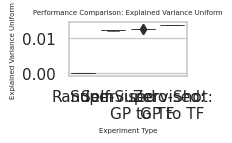

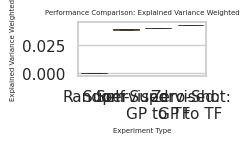

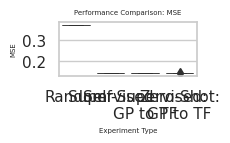

In [26]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Performance Comparison: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_nn_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Performance Comparison: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_nn_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Performance Comparison: MSE', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_nn_MSE.svg", bbox_inches='tight')
plt.show()

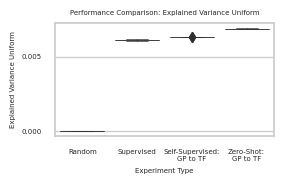

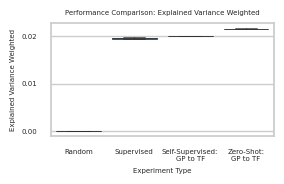

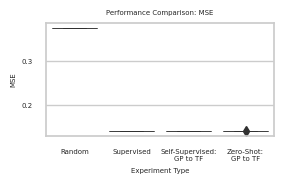

In [27]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_baseline, color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Performance Comparison: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_nn_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Performance Comparison: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_nn_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Performance Comparison: MSE', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_nn_MSE.svg", bbox_inches='tight')
plt.show()

### **Circulating Immune cells -- CV19 infection, vaccination and HC**

- 195,632 cells
- 10x 5' v1 10x 5' v2
- B Cell (21190), CD4-positive, alpha-beta T cell (61350), CD8-positive, alpha-beta T cell (35752), T cell (1407), dendritic cell (3368), gamma-delta T cell (3184), monocyte (38476), mucosal invariant T cell (1244), natural killer cell (28834), stem cell (827) 

In [28]:
ood_set = 'circ_imm'

In [29]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# Show the first few rows to get an overview of the data
df

experiment  Explained Variance Uniform  \
5                               CN_MLP_gp_to_tf                    0.026249   
6                           CN_MLP_gp_to_tfrun1                    0.026016   
7                           CN_MLP_gp_to_tfrun2                    0.025970   
8                           CN_MLP_gp_to_tfrun3                    0.026072   
9                           CN_MLP_gp_to_tfrun4                    0.025942   
21                       CN_NegBin_gp_to_tfrun0                    0.031065   
22                       CN_NegBin_gp_to_tfrun1                    0.031067   
23                       CN_NegBin_gp_to_tfrun2                    0.031038   
24                       CN_NegBin_gp_to_tfrun3                    0.031073   
25                       CN_NegBin_gp_to_tfrun4                    0.031163   
0                          CN_No_SSL_CN_MLPrun0                    0.024970   
1                          CN_No_SSL_CN_MLPrun1                    0.025169   
2                          CN_No_SSL_CN_MLPrun2                    0.025059   
3                          CN_No_SSL_CN_MLPrun3                    0.025158   
4                          CN_No_SSL_CN_MLPrun4                    0.024852   
16                     CN_No_SSL_CN_run0NegBin_                    0.029371   
17                     CN_No_SSL_CN_run1NegBin_                    0.029113   
18                     CN_No_SSL_CN_run2NegBin_                    0.029094   
19                     CN_No_SSL_CN_run3NegBin_                    0.029028   
20                     CN_No_SSL_CN_run4NegBin_                    0.029165   
10                CN_SSL_CN_CN_MLP_gp_to_tfrun0                    0.025654   
11                CN_SSL_CN_CN_MLP_gp_to_tfrun1                    0.024939   
12                CN_SSL_CN_CN_MLP_gp_to_tfrun2                    0.025480   
13                CN_SSL_CN_CN_MLP_gp_to_tfrun3                    0.024919   
14                CN_SSL_CN_CN_MLP_gp_to_tfrun4                    0.025508   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.029713   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.029846   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.029760   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.029786   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.029801   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
5                      0.072848  0.187753  
6                      0.072213  0.187864  
7                      0.072127  0.187864  
8                      0.072238  0.187888  
9                      0.072049  0.187910  
21                     0.091313  0.164153  
22                     0.091281  0.163992  
23                     0.091322  0.164009  
24                     0.091274  0.164218  
25                     0.091319  0.164091  
0                      0.069343  0.188671  
1                      0.069482  0.188542  
2                      0.069249  0.188540  
3                      0.069396  0.188604  
4                      0.068833  0.188796  
16                     0.087914  0.164859  
17                     0.087265  0.165101  
18                     0.087432  0.165183  
19                     0.086988  0.165218  
20                     0.087373  0.165027  
10                     0.071172  0.188363  
11                     0.068612  0.188900  
12                     0.070745  0.188394  
13                     0.069493  0.188725  
14                     0.070597  0.188447  
26                     0.088606  0.164838  
27                     0.088890  0.164793  
28                     0.088742  0.164854  
29                     0.088812  0.164815  
30                     0.088777  0.164827  
15                     0.000000  0.409742

In [30]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  Explained Variance Uniform  \
21                       CN_NegBin_gp_to_tfrun0                    0.031065   
22                       CN_NegBin_gp_to_tfrun1                    0.031067   
23                       CN_NegBin_gp_to_tfrun2                    0.031038   
24                       CN_NegBin_gp_to_tfrun3                    0.031073   
25                       CN_NegBin_gp_to_tfrun4                    0.031163   
16                     CN_No_SSL_CN_run0NegBin_                    0.029371   
17                     CN_No_SSL_CN_run1NegBin_                    0.029113   
18                     CN_No_SSL_CN_run2NegBin_                    0.029094   
19                     CN_No_SSL_CN_run3NegBin_                    0.029028   
20                     CN_No_SSL_CN_run4NegBin_                    0.029165   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.029713   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.029846   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.029760   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.029786   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.029801   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
21                     0.091313  0.164153  
22                     0.091281  0.163992  
23                     0.091322  0.164009  
24                     0.091274  0.164218  
25                     0.091319  0.164091  
16                     0.087914  0.164859  
17                     0.087265  0.165101  
18                     0.087432  0.165183  
19                     0.086988  0.165218  
20                     0.087373  0.165027  
26                     0.088606  0.164838  
27                     0.088890  0.164793  
28                     0.088742  0.164854  
29                     0.088812  0.164815  
30                     0.088777  0.164827  
15                     0.000000  0.409742

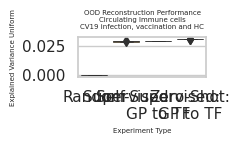

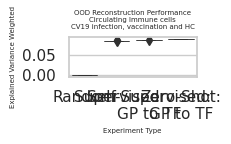

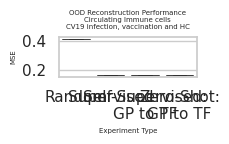

In [31]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_circ_imm_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_circ_imm_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_circ_imm_MSE.svg", bbox_inches='tight')
plt.show()

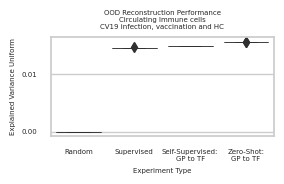

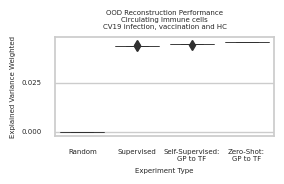

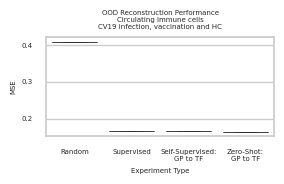

In [32]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_baseline, color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3,2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_circ_imm_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_circ_imm_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_circ_imm_MSE.svg", bbox_inches='tight')
plt.show()

### **Single-cell analysis of prenatal and postnatal human cortical development**

- 709,372 cells
- 110x 3' v2, 10x 3' v3, 10x multiome
- astrocyte (67868), microglial cell (15857), native cell (15828), neural cell (537452), oligodendrocyte (40875), oligodendrocyte precursor cell (31392)

In [33]:
ood_set = 'cort_dev'

In [34]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.

# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale

# Show the first few rows to get an overview of the data
df

experiment  Explained Variance Uniform  \
5                               CN_MLP_gp_to_tf                    0.017552   
6                           CN_MLP_gp_to_tfrun1                    0.017088   
7                           CN_MLP_gp_to_tfrun2                    0.017473   
8                           CN_MLP_gp_to_tfrun3                    0.016492   
9                           CN_MLP_gp_to_tfrun4                    0.017229   
21                       CN_NegBin_gp_to_tfrun0                    0.020516   
22                       CN_NegBin_gp_to_tfrun1                    0.020761   
23                       CN_NegBin_gp_to_tfrun2                    0.020024   
24                       CN_NegBin_gp_to_tfrun3                    0.020326   
25                       CN_NegBin_gp_to_tfrun4                    0.019827   
0                          CN_No_SSL_CN_MLPrun0                    0.015215   
1                          CN_No_SSL_CN_MLPrun1                    0.015342   
2                          CN_No_SSL_CN_MLPrun2                    0.016210   
3                          CN_No_SSL_CN_MLPrun3                    0.015093   
4                          CN_No_SSL_CN_MLPrun4                    0.015822   
16                     CN_No_SSL_CN_run0NegBin_                    0.017135   
17                     CN_No_SSL_CN_run1NegBin_                    0.018928   
18                     CN_No_SSL_CN_run2NegBin_                    0.017994   
19                     CN_No_SSL_CN_run3NegBin_                    0.017893   
20                     CN_No_SSL_CN_run4NegBin_                    0.018520   
10                CN_SSL_CN_CN_MLP_gp_to_tfrun0                    0.016254   
11                CN_SSL_CN_CN_MLP_gp_to_tfrun1                    0.016553   
12                CN_SSL_CN_CN_MLP_gp_to_tfrun2                    0.016465   
13                CN_SSL_CN_CN_MLP_gp_to_tfrun3                    0.016253   
14                CN_SSL_CN_CN_MLP_gp_to_tfrun4                    0.016963   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.018811   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.018853   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.018454   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.018370   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.018816   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
5                      0.065724  0.209839  
6                      0.065098  0.210036  
7                      0.064634  0.209988  
8                      0.064929  0.210147  
9                      0.065143  0.209932  
21                     0.077377  0.202370  
22                     0.077434  0.202159  
23                     0.077156  0.202410  
24                     0.077448  0.202416  
25                     0.077232  0.202568  
0                      0.061965  0.211096  
1                      0.062083  0.211102  
2                      0.062225  0.210686  
3                      0.061515  0.211041  
4                      0.062232  0.211032  
16                     0.073678  0.203821  
17                     0.073976  0.203417  
18                     0.073692  0.203793  
19                     0.072983  0.203862  
20                     0.073770  0.203333  
10                     0.063888  0.210637  
11                     0.061948  0.211004  
12                     0.063897  0.210680  
13                     0.062471  0.211026  
14                     0.063608  0.210589  
26                     0.075190  0.203309  
27                     0.075305  0.203326  
28                     0.075186  0.203436  
29                     0.075170  0.203395  
30                     0.075203  0.203280  
15                     0.000000  0.408492

In [35]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  Explained Variance Uniform  \
21                       CN_NegBin_gp_to_tfrun0                    0.020516   
22                       CN_NegBin_gp_to_tfrun1                    0.020761   
23                       CN_NegBin_gp_to_tfrun2                    0.020024   
24                       CN_NegBin_gp_to_tfrun3                    0.020326   
25                       CN_NegBin_gp_to_tfrun4                    0.019827   
16                     CN_No_SSL_CN_run0NegBin_                    0.017135   
17                     CN_No_SSL_CN_run1NegBin_                    0.018928   
18                     CN_No_SSL_CN_run2NegBin_                    0.017994   
19                     CN_No_SSL_CN_run3NegBin_                    0.017893   
20                     CN_No_SSL_CN_run4NegBin_                    0.018520   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.018811   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.018853   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.018454   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.018370   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.018816   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
21                     0.077377  0.202370  
22                     0.077434  0.202159  
23                     0.077156  0.202410  
24                     0.077448  0.202416  
25                     0.077232  0.202568  
16                     0.073678  0.203821  
17                     0.073976  0.203417  
18                     0.073692  0.203793  
19                     0.072983  0.203862  
20                     0.073770  0.203333  
26                     0.075190  0.203309  
27                     0.075305  0.203326  
28                     0.075186  0.203436  
29                     0.075170  0.203395  
30                     0.075203  0.203280  
15                     0.000000  0.408492

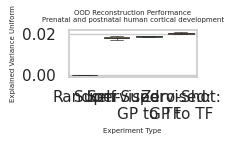

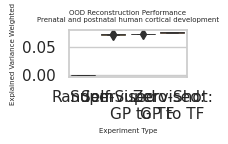

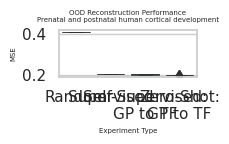

In [36]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_cort_dev_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_cort_dev_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_cort_dev_MSE.svg", bbox_inches='tight')
plt.show()

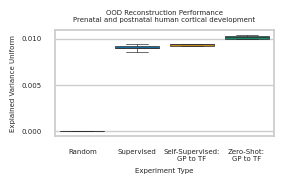

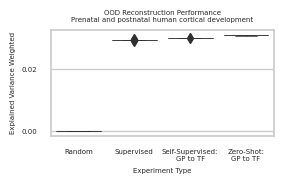

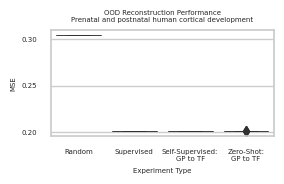

In [37]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_baseline, color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3,2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_cort_dev_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3,2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_cort_dev_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_cort_dev_MSE.svg", bbox_inches='tight')
plt.show()

### **Human: Great apes study**

- 156,285 cells
- 10x 3' v3 Smart-seq v4
- L2/3-6 intratelencephalic projecting glutamatergic cortical neuron (85276), L5 something not included (392), L6b glutamatergic cortical neuron (3415), astrocyte of the cerebral cortex (3047), caudial ganglio... not included (844), cerebral cortex endothelial cell (168), chandelier pval (728), cortocothalami... (3118), lamp5 GABAeric... (6416), microglial cell (1263), near-projecting ... (3461), oligodendrocyte (7876), oligodendrocyte precursor cell (2392), pvalb GABAergic (11778), sncg GABAergic (2025), sst GABAergic cortical interneuron (13593), vascular leptomeningeal cell (276), vip GABAergic cortical interneuron (10219)

In [38]:
ood_set = 'great_apes'

In [39]:
# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_comp_' + ood_set + '.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
df['Explained Variance Uniform'][df['experiment'] == 'Random'] = 0.
df['Explained Variance Weighted'][df['experiment'] == 'Random'] = 0.
# df = df[~df['experiment'].isin(['Random'])]  # Random is too bad and destroys the scale

# Show the first few rows to get an overview of the data
df

experiment  Explained Variance Uniform  \
5                               CN_MLP_gp_to_tf                    0.024444   
6                           CN_MLP_gp_to_tfrun1                    0.021353   
7                           CN_MLP_gp_to_tfrun2                    0.023180   
8                           CN_MLP_gp_to_tfrun3                    0.022981   
9                           CN_MLP_gp_to_tfrun4                    0.023337   
21                       CN_NegBin_gp_to_tfrun0                    0.005581   
22                       CN_NegBin_gp_to_tfrun1                   -0.037511   
23                       CN_NegBin_gp_to_tfrun2                   -0.097389   
24                       CN_NegBin_gp_to_tfrun3                  -24.085745   
25                       CN_NegBin_gp_to_tfrun4                   -0.038573   
0                          CN_No_SSL_CN_MLPrun0                    0.023844   
1                          CN_No_SSL_CN_MLPrun1                    0.022037   
2                          CN_No_SSL_CN_MLPrun2                    0.021979   
3                          CN_No_SSL_CN_MLPrun3                    0.023855   
4                          CN_No_SSL_CN_MLPrun4                    0.022016   
16                     CN_No_SSL_CN_run0NegBin_                    0.002519   
17                     CN_No_SSL_CN_run1NegBin_                    0.002919   
18                     CN_No_SSL_CN_run2NegBin_                    0.004591   
19                     CN_No_SSL_CN_run3NegBin_                   -8.083727   
20                     CN_No_SSL_CN_run4NegBin_                    0.001042   
10                CN_SSL_CN_CN_MLP_gp_to_tfrun0                    0.021072   
11                CN_SSL_CN_CN_MLP_gp_to_tfrun1                    0.019565   
12                CN_SSL_CN_CN_MLP_gp_to_tfrun2                    0.022269   
13                CN_SSL_CN_CN_MLP_gp_to_tfrun3                    0.022656   
14                CN_SSL_CN_CN_MLP_gp_to_tfrun4                    0.022266   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.004618   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.005593   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.001192   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.005670   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.006094   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
5                      0.059756  0.136057  
6                      0.057891  0.135582  
7                      0.059845  0.135237  
8                      0.059238  0.135176  
9                      0.060068  0.134910  
21                     0.051207  0.146498  
22                     0.044358  0.145583  
23                     0.015866  0.146910  
24                    -0.623719  0.326163  
25                     0.041535  0.146178  
0                      0.058945  0.136180  
1                      0.056952  0.136895  
2                      0.056957  0.136286  
3                      0.058483  0.136174  
4                      0.055970  0.137298  
16                     0.047960  0.146269  
17                     0.047754  0.147673  
18                     0.047177  0.146598  
19                    -0.194000  0.200676  
20                     0.046750  0.147277  
10                     0.057021  0.136827  
11                     0.056541  0.136783  
12                     0.056096  0.137578  
13                     0.053926  0.138364  
14                     0.057269  0.136977  
26                     0.051213  0.147820  
27                     0.050630  0.147567  
28                     0.048843  0.146410  
29                     0.050604  0.147618  
30                     0.051302  0.146444  
15                     0.000000  0.291431

In [40]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_run0NegBin_',
                    'CN_No_SSL_CN_run1NegBin_',
                    'CN_No_SSL_CN_run2NegBin_',
                    'CN_No_SSL_CN_run3NegBin_',
                    'CN_No_SSL_CN_run4NegBin_', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_',
                    'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  Explained Variance Uniform  \
21                       CN_NegBin_gp_to_tfrun0                    0.005581   
22                       CN_NegBin_gp_to_tfrun1                   -0.037511   
23                       CN_NegBin_gp_to_tfrun2                   -0.097389   
24                       CN_NegBin_gp_to_tfrun3                  -24.085745   
25                       CN_NegBin_gp_to_tfrun4                   -0.038573   
16                     CN_No_SSL_CN_run0NegBin_                    0.002519   
17                     CN_No_SSL_CN_run1NegBin_                    0.002919   
18                     CN_No_SSL_CN_run2NegBin_                    0.004591   
19                     CN_No_SSL_CN_run3NegBin_                   -8.083727   
20                     CN_No_SSL_CN_run4NegBin_                    0.001042   
26  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run0NegBin_                    0.004618   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run1NegBin_                    0.005593   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run2NegBin_                    0.001192   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run3NegBin_                    0.005670   
30  CN_SSL_CN_CN_NegBin_gp_to_tfrun0run4NegBin_                    0.006094   
15                                       Random                    0.000000   

    Explained Variance Weighted       MSE  
21                     0.051207  0.146498  
22                     0.044358  0.145583  
23                     0.015866  0.146910  
24                    -0.623719  0.326163  
25                     0.041535  0.146178  
16                     0.047960  0.146269  
17                     0.047754  0.147673  
18                     0.047177  0.146598  
19                    -0.194000  0.200676  
20                     0.046750  0.147277  
26                     0.051213  0.147820  
27                     0.050630  0.147567  
28                     0.048843  0.146410  
29                     0.050604  0.147618  
30                     0.051302  0.146444  
15                     0.000000  0.291431

In [41]:
df = df[~df['experiment'].isin(['CN_NegBin_gp_to_tfrun3', 'CN_NegBin_gp_to_tfrun2', 'CN_No_SSL_CN_run3NegBin_', ])]  # Remove Outliers

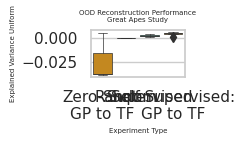

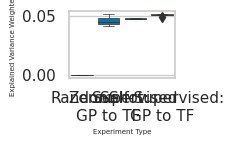

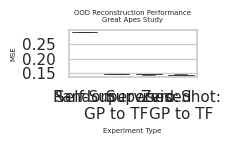

In [42]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_ssl, color_supervised, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.4, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_Great_Apes_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.4, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
# ax2.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_Great_Apes_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.4, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/OOD_Great_Apes_MSE.svg", bbox_inches='tight')
plt.show()

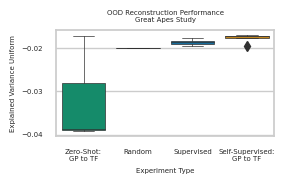

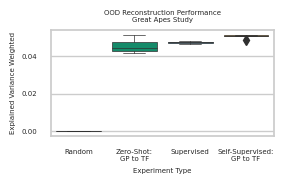

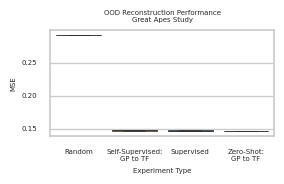

In [43]:
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Ensure that the metric columns are of float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)  # low MSE = better

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors1 = [color_zeroshot, color_baseline, color_supervised, color_ssl]
model_colors2 = [color_baseline, color_zeroshot, color_supervised, color_ssl]
model_colors3 = [color_baseline, color_ssl, color_supervised, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(3, 2))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors1)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_Great_Apes_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(3, 2))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors2)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_Great_Apes_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(3, 2))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors3)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('OOD Reconstruction Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_OOD_Great_Apes_MSE.svg", bbox_inches='tight')
plt.show()

# Fig 4: Individual Atlas

### HLCA

In [44]:
supervised_subset = 148  # HLCA

In [45]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_148.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
# df = df[~df['experiment'].str.contains('NegBin')]

# Show the first few rows to get an overview of the data
df

experiment  \
2                                        CN_MLP_gp_to_tf   
3                                    CN_MLP_gp_to_tfrun1   
4                                    CN_MLP_gp_to_tfrun2   
5                                    CN_MLP_gp_to_tfrun3   
6                                    CN_MLP_gp_to_tfrun4   
28                                CN_NegBin_gp_to_tfrun0   
29                                CN_NegBin_gp_to_tfrun1   
30                                CN_NegBin_gp_to_tfrun2   
31                                CN_NegBin_gp_to_tfrun3   
32                                CN_NegBin_gp_to_tfrun4   
7                          CN_No_SSL_CN_MLPnew_run0_HLCA   
8                          CN_No_SSL_CN_MLPnew_run1_HLCA   
9                          CN_No_SSL_CN_MLPnew_run2_HLCA   
10                         CN_No_SSL_CN_MLPnew_run3_HLCA   
11                         CN_No_SSL_CN_MLPnew_run4_HLCA   
0                              CN_No_SSL_CN_MLPrun0_HLCA   
17                     CN_No_SSL_CN_new_run0NegBin__HLCA   
18                     CN_No_SSL_CN_new_run1NegBin__HLCA   
19                     CN_No_SSL_CN_new_run2NegBin__HLCA   
20                     CN_No_SSL_CN_new_run3NegBin__HLCA   
21                     CN_No_SSL_CN_new_run4NegBin__HLCA   
22         CN_SSL_CN_CN_MLP_gp_to_tfnew_run0NegBin__HLCA   
12                CN_SSL_CN_CN_MLP_gp_to_tfnew_run0_HLCA   
23         CN_SSL_CN_CN_MLP_gp_to_tfnew_run1NegBin__HLCA   
13                CN_SSL_CN_CN_MLP_gp_to_tfnew_run1_HLCA   
24         CN_SSL_CN_CN_MLP_gp_to_tfnew_run2NegBin__HLCA   
14                CN_SSL_CN_CN_MLP_gp_to_tfnew_run2_HLCA   
25         CN_SSL_CN_CN_MLP_gp_to_tfnew_run3NegBin__HLCA   
15                CN_SSL_CN_CN_MLP_gp_to_tfnew_run3_HLCA   
26         CN_SSL_CN_CN_MLP_gp_to_tfnew_run4NegBin__HLCA   
16                CN_SSL_CN_CN_MLP_gp_to_tfnew_run4_HLCA   
1                     CN_SSL_CN_CN_MLP_gp_to_tfrun0_HLCA   
33  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__HLCA   
34  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__HLCA   
35  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__HLCA   
36  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__HLCA   
37  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__HLCA   
27                                                Random   

    Explained Variance Uniform  Explained Variance Weighted       MSE  
2                     0.045098                     0.182332  0.131056  
3                     0.044219                     0.181308  0.131141  
4                     0.044151                     0.181282  0.131127  
5                     0.044105                     0.181357  0.131149  
6                     0.043465                     0.181216  0.131137  
28                    0.048608                     0.271839  0.094054  
29                    0.047480                     0.271660  0.094078  
30                    0.047602                     0.271747  0.094065  
31                    0.047968                     0.271646  0.094073  
32                    0.049100                     0.271641  0.094071  
7                     0.040057                     0.177423  0.131620  
8                     0.043618                     0.178457  0.131513  
9                     0.042349                     0.177072  0.131653  
10                    0.040898                     0.177244  0.131583  
11                    0.046689                     0.178918  0.131685  
0                     0.045847                     0.179100  0.131585  
17                    0.036961                     0.264383  0.095144  
18                    0.043978                     0.268769  0.094476  
19                    0.039708                     0.267578  0.094646  
20                    0.042057                     0.267642  0.094616  
21                    0.043333                     0.269099  0.094424  
22                    0.052017                     0.268356  0.094642  
12                    0.047178                   

In [46]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_new_run0NegBin__HLCA',
                    'CN_No_SSL_CN_new_run1NegBin__HLCA',
                    'CN_No_SSL_CN_new_run2NegBin__HLCA',
                    'CN_No_SSL_CN_new_run3NegBin__HLCA',
                    'CN_No_SSL_CN_new_run4NegBin__HLCA', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__HLCA',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__HLCA',
                    # 'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  \
28                                CN_NegBin_gp_to_tfrun0   
29                                CN_NegBin_gp_to_tfrun1   
30                                CN_NegBin_gp_to_tfrun2   
31                                CN_NegBin_gp_to_tfrun3   
32                                CN_NegBin_gp_to_tfrun4   
17                     CN_No_SSL_CN_new_run0NegBin__HLCA   
18                     CN_No_SSL_CN_new_run1NegBin__HLCA   
19                     CN_No_SSL_CN_new_run2NegBin__HLCA   
20                     CN_No_SSL_CN_new_run3NegBin__HLCA   
21                     CN_No_SSL_CN_new_run4NegBin__HLCA   
33  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__HLCA   
34  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__HLCA   
35  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__HLCA   
36  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__HLCA   
37  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__HLCA   

    Explained Variance Uniform  Explained Variance Weighted       MSE  
28                    0.048608                     0.271839  0.094054  
29                    0.047480                     0.271660  0.094078  
30                    0.047602                     0.271747  0.094065  
31                    0.047968                     0.271646  0.094073  
32                    0.049100                     0.271641  0.094071  
17                    0.036961                     0.264383  0.095144  
18                    0.043978                     0.268769  0.094476  
19                    0.039708                     0.267578  0.094646  
20                    0.042057                     0.267642  0.094616  
21                    0.043333                     0.269099  0.094424  
33                    0.048676                     0.273782  0.093916  
34                    0.047655                     0.272924  0.094034  
35                    0.049651                     0.273099  0.094000  
36                    0.050695                     0.273202  0.094015  
37                    0.047881                     0.273836  0.093902

In [47]:
np.mean((0.273782, 0.272924, 0.273099, 0.273202, 0.273836))

0.2733686

In [48]:
# Remove the old models
# outliers = ['CN_No_SSL_CN_MLPrun0_HLCA', 'CN_SSL_CN_CN_MLP_gp_to_tfrun0_HLCA']
# df = df[~df['experiment'].isin(outliers)]

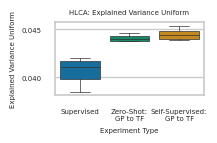

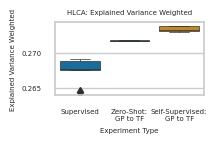

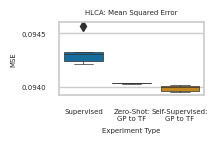

In [49]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN_' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    elif 'Random' in row['experiment']:
        return 'Random'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
# ordered_types_mse = mean_mse.index.tolist()

# somehow this didn't work
ordered_types_mse = [
    'Supervised' ,
    'Zero-Shot:\nGP to TF',     
    'Self-Supervised:\nGP to TF',  
]

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_zeroshot, color_ssl]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('HLCA: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_HLCA_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('HLCA: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_HLCA_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('HLCA: Mean Squared Error', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_HLCA_MSE.svg", bbox_inches='tight')
plt.show()

### PBMC

In [50]:
supervised_subset = 41  # PBMC

In [73]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_41.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)

# Show the first few rows to get an overview of the data
df

experiment  \
2                                        CN_MLP_gp_to_tf   
3                                    CN_MLP_gp_to_tfrun1   
4                                    CN_MLP_gp_to_tfrun2   
5                                    CN_MLP_gp_to_tfrun3   
6                                    CN_MLP_gp_to_tfrun4   
27                                CN_NegBin_gp_to_tfrun0   
28                                CN_NegBin_gp_to_tfrun1   
29                                CN_NegBin_gp_to_tfrun2   
30                                CN_NegBin_gp_to_tfrun3   
31                                CN_NegBin_gp_to_tfrun4   
16                         CN_No_SSL_CN_MLPnew_run0_PBMC   
17                         CN_No_SSL_CN_MLPnew_run1_PBMC   
18                         CN_No_SSL_CN_MLPnew_run2_PBMC   
19                         CN_No_SSL_CN_MLPnew_run3_PBMC   
20                         CN_No_SSL_CN_MLPnew_run4_PBMC   
0                              CN_No_SSL_CN_MLPrun0_PBMC   
7                      CN_No_SSL_CN_new_run0NegBin__PBMC   
8                      CN_No_SSL_CN_new_run1NegBin__PBMC   
9                      CN_No_SSL_CN_new_run2NegBin__PBMC   
10                     CN_No_SSL_CN_new_run3NegBin__PBMC   
26                     CN_No_SSL_CN_new_run4NegBin__PBMC   
38                     CN_No_SSL_CN_new_run5NegBin__PBMC   
39                     CN_No_SSL_CN_new_run6NegBin__PBMC   
40                     CN_No_SSL_CN_new_run7NegBin__PBMC   
11         CN_SSL_CN_CN_MLP_gp_to_tfnew_run0NegBin__PBMC   
21                CN_SSL_CN_CN_MLP_gp_to_tfnew_run0_PBMC   
12         CN_SSL_CN_CN_MLP_gp_to_tfnew_run1NegBin__PBMC   
22                CN_SSL_CN_CN_MLP_gp_to_tfnew_run1_PBMC   
13         CN_SSL_CN_CN_MLP_gp_to_tfnew_run2NegBin__PBMC   
23                CN_SSL_CN_CN_MLP_gp_to_tfnew_run2_PBMC   
14         CN_SSL_CN_CN_MLP_gp_to_tfnew_run3NegBin__PBMC   
24                CN_SSL_CN_CN_MLP_gp_to_tfnew_run3_PBMC   
15         CN_SSL_CN_CN_MLP_gp_to_tfnew_run4NegBin__PBMC   
25                CN_SSL_CN_CN_MLP_gp_to_tfnew_run4_PBMC   
1                     CN_SSL_CN_CN_MLP_gp_to_tfrun0_PBMC   
32  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__PBMC   
33  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__PBMC   
35  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__PBMC   
36  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__PBMC   
37  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__PBMC   
41  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run5NegBin__PBMC   
42  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run6NegBin__PBMC   
34                                                Random   

    Explained Variance Uniform  Explained Variance Weighted       MSE  
2                     0.020710                     0.089073  0.151431  
3                     0.020646                     0.088599  0.151463  
4                     0.020673                     0.088552  0.151450  
5                     0.020637                     0.088483  0.151486  
6                     0.020687                     0.088612  0.151471  
27                    0.025738                     0.139632  0.112569  
28                    0.025799                     0.139740  0.112571  
29                    0.025789                     0.139750  0.112569  
30                    0.025768                     0.139874  0.112548  
31                    0.025807                     0.139762  0.112558  
16                    0.018249                     0.076690  0.152769  
17                    0.018725                     0.078069  0.152583  
18                    0.014456                     0.060576  0.154486  
19                    0.017560                     0.072442  0.153107  
20                    0.016843                     0.068044  0.153724  
0                     0.020281                     0.086240  0.151493  
7                     0.025361                     0.140740  0.112391  
8                     0.024767                     0.138389  0.112702  
9                     0.024969       

In [74]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_new_run2NegBin__PBMC',
                    'CN_No_SSL_CN_new_run5NegBin__PBMC',
                    'CN_No_SSL_CN_new_run1NegBin__PBMC',
                    'CN_No_SSL_CN_new_run6NegBin__PBMC',
                    'CN_No_SSL_CN_new_run4NegBin__PBMC', 
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__PBMC',
                    # 'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__PBMC',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run6NegBin__PBMC',
                    # 'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  \
27                                CN_NegBin_gp_to_tfrun0   
28                                CN_NegBin_gp_to_tfrun1   
29                                CN_NegBin_gp_to_tfrun2   
30                                CN_NegBin_gp_to_tfrun3   
31                                CN_NegBin_gp_to_tfrun4   
8                      CN_No_SSL_CN_new_run1NegBin__PBMC   
9                      CN_No_SSL_CN_new_run2NegBin__PBMC   
26                     CN_No_SSL_CN_new_run4NegBin__PBMC   
38                     CN_No_SSL_CN_new_run5NegBin__PBMC   
39                     CN_No_SSL_CN_new_run6NegBin__PBMC   
32  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__PBMC   
33  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__PBMC   
35  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__PBMC   
36  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__PBMC   
42  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run6NegBin__PBMC   

    Explained Variance Uniform  Explained Variance Weighted       MSE  
27                    0.025738                     0.139632  0.112569  
28                    0.025799                     0.139740  0.112571  
29                    0.025789                     0.139750  0.112569  
30                    0.025768                     0.139874  0.112548  
31                    0.025807                     0.139762  0.112558  
8                     0.024767                     0.138389  0.112702  
9                     0.024969                     0.138063  0.112725  
26                    0.024975                     0.138858  0.112638  
38                    0.024894                     0.138295  0.112721  
39                    0.024959                     0.138638  0.112688  
32                    0.024916                     0.138712  0.112653  
33                    0.024924                     0.138744  0.112666  
35                    0.025053                     0.138502  0.112730  
36                    0.025062                     0.139419  0.112573  
42                    0.024854                     0.138981  0.112667

In [59]:
np.mean((0.138712, 0.138744	, 0.138502, 0.139419, 0.138981))

0.1388716

In [30]:
# Remove the old models
# outliers = ['CN_No_SSL_CN_MLPrun0_PBMC', 'CN_SSL_CN_CN_MLP_gp_to_tfrun0_PBMC']
# df = df[~df['experiment'].isin(outliers)]

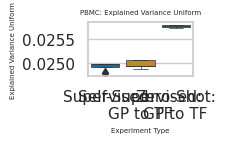

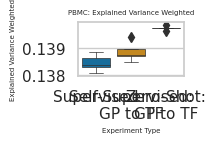

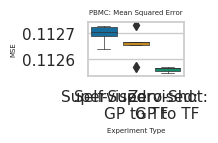

In [75]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# somehow this didn't work
ordered_types_mse = [
    'Supervised' ,
    'Self-Supervised:\nGP to TF',  
    'Zero-Shot:\nGP to TF',     
    
]

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('PBMC: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_PBMC_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('PBMC: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_PBMC_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('PBMC: Mean Squared Error', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_PBMC_MSE.svg", bbox_inches='tight')
plt.show()

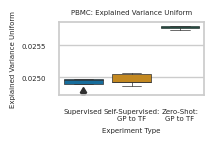

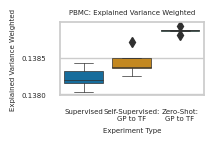

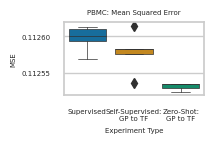

In [60]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = mean_mse.index.tolist()

# somehow this didn't work
ordered_types_mse = [
    'Supervised' ,
    'Self-Supervised:\nGP to TF',  
    'Zero-Shot:\nGP to TF',     
    
]

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('PBMC: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_PBMC_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('PBMC: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_PBMC_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('PBMC: Mean Squared Error', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_PBMC_MSE.svg", bbox_inches='tight')
plt.show()

### Tabula Sapiens

In [66]:
supervised_subset = 87  # Tabula Sapiens

In [67]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'reconstruction', 'rec_report_87.csv')
pd.set_option('display.max_colwidth', 1000)

df = pd.read_csv(file_path)
df = df.sort_values(by='experiment', ascending=True)
# df = df[~df['experiment'].str.contains('NegBin')]


# Show the first few rows to get an overview of the data
df

experiment  \
2                                                  CN_MLP_gp_to_tf   
3                                              CN_MLP_gp_to_tfrun1   
4                                              CN_MLP_gp_to_tfrun2   
5                                              CN_MLP_gp_to_tfrun3   
6                                              CN_MLP_gp_to_tfrun4   
18                                          CN_NegBin_gp_to_tfrun0   
19                                          CN_NegBin_gp_to_tfrun1   
20                                          CN_NegBin_gp_to_tfrun2   
21                                          CN_NegBin_gp_to_tfrun3   
22                                          CN_NegBin_gp_to_tfrun4   
7                          CN_No_SSL_CN_MLPnew_run0_Tabula_Sapiens   
8                          CN_No_SSL_CN_MLPnew_run1_Tabula_Sapiens   
9                          CN_No_SSL_CN_MLPnew_run2_Tabula_Sapiens   
10                         CN_No_SSL_CN_MLPnew_run3_Tabula_Sapiens   
11                         CN_No_SSL_CN_MLPnew_run4_Tabula_Sapiens   
0                              CN_No_SSL_CN_MLPrun0_Tabula_Sapiens   
23                     CN_No_SSL_CN_new_run0NegBin__Tabula_Sapiens   
30                     CN_No_SSL_CN_new_run1NegBin__Tabula_Sapiens   
31                     CN_No_SSL_CN_new_run2NegBin__Tabula_Sapiens   
32                     CN_No_SSL_CN_new_run3NegBin__Tabula_Sapiens   
33                     CN_No_SSL_CN_new_run4NegBin__Tabula_Sapiens   
36                     CN_No_SSL_CN_new_run5NegBin__Tabula_Sapiens   
34                     CN_No_SSL_CN_new_run6NegBin__Tabula_Sapiens   
35                     CN_No_SSL_CN_new_run7NegBin__Tabula_Sapiens   
37                     CN_No_SSL_CN_new_run8NegBin__Tabula_Sapiens   
38                     CN_No_SSL_CN_new_run9NegBin__Tabula_Sapiens   
12         CN_SSL_CN_CN_MLP_gp_to_tfnew_run0NegBin__Tabula_Sapiens   
13                CN_SSL_CN_CN_MLP_gp_to_tfnew_run0_Tabula_Sapiens   
14                CN_SSL_CN_CN_MLP_gp_to_tfnew_run1_Tabula_Sapiens   
15                CN_SSL_CN_CN_MLP_gp_to_tfnew_run2_Tabula_Sapiens   
16                CN_SSL_CN_CN_MLP_gp_to_tfnew_run3_Tabula_Sapiens   
17                CN_SSL_CN_CN_MLP_gp_to_tfnew_run4_Tabula_Sapiens   
1                               CN_SSL_CN_CN_MLP_gp_to_tfrun0_PBMC   
24  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__Tabula_Sapiens   
25  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__Tabula_Sapiens   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__Tabula_Sapiens   
28  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__Tabula_Sapiens   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__Tabula_Sapiens   
26                                                          Random   

    Explained Variance Uniform  Explained Variance Weighted           MSE  
2                 6.148518e-02                 1.981706e-01  1.234487e-01  
3                 6.075163e-02                 1.975736e-01  1.235797e-01  
4                 6.127269e-02                 1.970689e-01  1.235991e-01  
5                 6.102591e-02                 1.973164e-01  1.235910e-01  
6                 5.974605e-02                 1.970365e-01  1.236104e-01  
18                6.875557e-02                 2.971505e-01  8.185578e-02  
19                6.232605e-02                 2.964328e-01  8.193294e-02  
20                6.488585e-02                 2.970955e-01  8.188640e-02  
21                6.509556e-02                 2.973587e-01  8.174691e-02  
22                6.602353e-02                 2.972398e-01  8.165064e-02  
7                 3.096966e-02                 1.653749e-01  1.265131e-01  
8                 3.683617e-02                 1.666006e-01  1.263149e-01  
9                 3.269668e-02                 1.642378e-01  1.266073e-01  
10                3.382445e-02                 1.636198e-01  1.266655e-01  
11                3.302178e-02                 1.656190e-01  1.264348e-01  
0                 3.262097e-02         

In [68]:
models_to_select = ['CN_NegBin_gp_to_tfrun0', 
                    'CN_NegBin_gp_to_tfrun1', 
                    'CN_NegBin_gp_to_tfrun2', 
                    'CN_NegBin_gp_to_tfrun3', 
                    'CN_NegBin_gp_to_tfrun4', 
                    'CN_No_SSL_CN_new_run5NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run6NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run7NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run8NegBin__Tabula_Sapiens',
                    'CN_No_SSL_CN_new_run9NegBin__Tabula_Sapiens',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__Tabula_Sapiens',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__Tabula_Sapiens',
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__Tabula_Sapiens',
                    # 'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run3NegBin__Tabula_Sapiens',  # Outlier
                    'CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__Tabula_Sapiens',
                    # 'Random'
                   ]

df = df[df['experiment'].isin(models_to_select)]
df

experiment  \
18                                          CN_NegBin_gp_to_tfrun0   
19                                          CN_NegBin_gp_to_tfrun1   
20                                          CN_NegBin_gp_to_tfrun2   
21                                          CN_NegBin_gp_to_tfrun3   
22                                          CN_NegBin_gp_to_tfrun4   
36                     CN_No_SSL_CN_new_run5NegBin__Tabula_Sapiens   
34                     CN_No_SSL_CN_new_run6NegBin__Tabula_Sapiens   
35                     CN_No_SSL_CN_new_run7NegBin__Tabula_Sapiens   
37                     CN_No_SSL_CN_new_run8NegBin__Tabula_Sapiens   
38                     CN_No_SSL_CN_new_run9NegBin__Tabula_Sapiens   
24  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run0NegBin__Tabula_Sapiens   
25  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run1NegBin__Tabula_Sapiens   
27  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run2NegBin__Tabula_Sapiens   
29  CN_SSL_CN_CN_NegBin_gp_to_tfrun0new_run4NegBin__Tabula_Sapiens   

    Explained Variance Uniform  Explained Variance Weighted       MSE  
18                    0.068756                     0.297151  0.081856  
19                    0.062326                     0.296433  0.081933  
20                    0.064886                     0.297096  0.081886  
21                    0.065096                     0.297359  0.081747  
22                    0.066024                     0.297240  0.081651  
36                    0.036998                     0.249776  0.087112  
34                    0.026674                     0.247666  0.087408  
35                    0.037480                     0.247925  0.087350  
37                    0.031704                     0.246705  0.087502  
38                    0.031885                     0.246449  0.087564  
24                    0.025676                     0.253818  0.086797  
25                    0.032577                     0.253668  0.086830  
27                    0.026397                     0.256315  0.086410  
29                    0.026322                     0.253263  0.086850

In [69]:
np.mean((0.249776, 0.247666, 0.247925, 0.246705, 0.246449))

0.24770419999999999

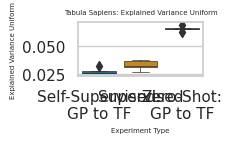

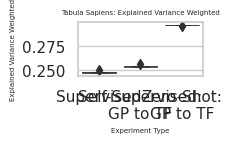

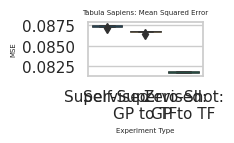

In [70]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = ['Supervised', 'Self-Supervised:\nGP to TF', 'Zero-Shot:\nGP to TF']
 # mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

# ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
# ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Tabula Sapiens: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/Tabula_Sapiens_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

# ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
# ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Tabula Sapiens: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/Tabula_Sapiens_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

# ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
# ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Tabula Sapiens: Mean Squared Error', fontdict=font)

plt.tight_layout()
# plt.savefig(RESULTS_FOLDER + "/reconstruction/Tabula_Sapiens_MSE.svg", bbox_inches='tight')
plt.show()

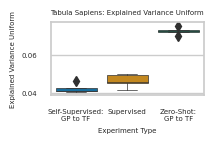

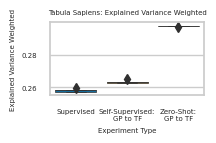

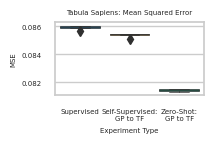

In [71]:
# Function to categorize experiments
def extract_experiment_type(row):
    if 'CN_SSL_CN_CN' in row['experiment']:
        return 'Self-Supervised:\nGP to TF'
    elif 'CN_No_SSL' in row['experiment']:
        return 'Supervised'
    elif 'CN_NegBin' in row['experiment']:
        return 'Zero-Shot:\nGP to TF'
    else:
        return 'Other'

# Apply the function to categorize experiments
df['Experiment Type'] = df.apply(extract_experiment_type, axis=1)

# Convert metric columns to float type
df['Explained Variance Uniform'] = df['Explained Variance Uniform'].astype(float)
df['Explained Variance Weighted'] = df['Explained Variance Weighted'].astype(float)
df['MSE'] = df['MSE'].astype(float)

# Calculate mean values for each experiment type
mean_uniform = df.groupby('Experiment Type')['Explained Variance Uniform'].mean().sort_values()
mean_weighted = df.groupby('Experiment Type')['Explained Variance Weighted'].mean().sort_values()
mean_mse = df.groupby('Experiment Type')['MSE'].mean().sort_values(ascending=False)

# Create ordered lists of experiment types based on mean values
ordered_types_uniform = mean_uniform.index.tolist()
ordered_types_weighted = mean_weighted.index.tolist()
ordered_types_mse = ['Supervised', 'Self-Supervised:\nGP to TF', 'Zero-Shot:\nGP to TF']
 # mean_mse.index.tolist()


# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
model_colors = [color_supervised, color_ssl, color_zeroshot]


# Plot for Explained Variance Uniform
plt.figure(figsize=(2.3, 1.6))
ax1 = sns.boxplot(x='Experiment Type', y='Explained Variance Uniform', data=df, order=ordered_types_uniform, linewidth=0.5, palette=model_colors)

ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

ax1.set_xlabel('Experiment Type', fontdict=font)
ax1.set_ylabel('Explained Variance Uniform', fontdict=font)
ax1.set_title('Tabula Sapiens: Explained Variance Uniform', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_Tabula_Sapiens_EV_Uniform.svg", bbox_inches='tight')
plt.show()

# Plot for Explained Variance Weighted
plt.figure(figsize=(2.3, 1.6))
ax2 = sns.boxplot(x='Experiment Type', y='Explained Variance Weighted', data=df, order=ordered_types_weighted, linewidth=0.5, palette=model_colors)

ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

ax2.set_xlabel('Experiment Type', fontdict=font)
ax2.set_ylabel('Explained Variance Weighted', fontdict=font)
ax2.set_title('Tabula Sapiens: Explained Variance Weighted', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_Tabula_Sapiens_EV_Weighted.svg", bbox_inches='tight')
plt.show()

# Plot for Mean Squared Error
plt.figure(figsize=(2.3, 1.6))
ax3 = sns.boxplot(x='Experiment Type', y='MSE', data=df, order=ordered_types_mse, linewidth=0.5, palette=model_colors)

ax3.set_xticklabels(ax3.get_xticklabels(), **tick_font)
ax3.set_yticklabels(ax3.get_yticklabels(), **tick_font)

ax3.set_xlabel('Experiment Type', fontdict=font)
ax3.set_ylabel('MSE', fontdict=font)
ax3.set_title('Tabula Sapiens: Mean Squared Error', fontdict=font)

plt.tight_layout()
plt.savefig(RESULTS_FOLDER + "/reconstruction/NegBin_Tabula_Sapiens_MSE.svg", bbox_inches='tight')
plt.show()

# Fig 5: Cell type specificities?

In [65]:
adata = anndata.AnnData(
    X=np.load(os.path.join(STORE_DIR, 'pca/x_pca_test_50.npy')), 
)
adata

AnnData object with n_obs × n_vars = 3448832 × 50

In [66]:
y_true_raw = dd.read_parquet(os.path.join(STORE_DIR, 'test'), columns='cell_type').compute().to_numpy()
y_true = y_true_raw
y_true

array([140, 129,  14, ...,  19, 129, 160])

In [67]:
cell_type_mapping = pd.read_parquet(os.path.join(STORE_DIR, 'categorical_lookup/cell_type.parquet'))
adata.obs['y_true'] = cell_type_mapping.loc[y_true].to_numpy().flatten()

In [68]:
ckpt_no_ssl = TRAINING_FOLDER + '/final_models/reconstruction/CN_No_SSL_CN_MLPrun0/default/version_3/checkpoints/best_checkpoint_val.ckpt'
ckpt_ssl = TRAINING_FOLDER + '/final_models/reconstruction/CN_SSL_CN_CN_MLP_gp_to_tfrun0/default/version_1/checkpoints/best_checkpoint_val.ckpt'

In [69]:
# init estim class
estim = EstimatorAutoEncoder(STORE_DIR)

# init datamodule
estim.init_datamodule(batch_size=4096) 

# init model
hidden_units = [512, 512, 256, 256, 64]
estim.init_model(
    model_type='mlp_ae',
    model_kwargs={
        'learning_rate': 1e-3,
        'weight_decay': 0.1,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'lr_scheduler_kwargs': {
            'step_size': 2,
            'gamma': 0.9,
            'verbose': True
        },
        'units_encoder': hidden_units,
        'units_decoder': hidden_units[::-1][1:],
    },
)

In [70]:
%autoreload 2
from self_supervision.tester.reconstruction.annotate_adata import annotate_best_model_rec

In [71]:
adata = annotate_best_model_rec(adata=adata, estim=estim, ckpt_no_ssl=ckpt_no_ssl, ckpt_ssl=ckpt_ssl)

In [72]:
adata

AnnData object with n_obs × n_vars = 3448832 × 50
    obs: 'y_true', 'better_model'

In [73]:
# Process adata
cell_freq = adata.obs['y_true'].value_counts()
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_filtered = adata[adata.obs['y_true'].isin(cells_to_plot)]

In [74]:
sc.pp.subsample(adata, n_obs=500_000)
# sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)

In [75]:
sns.set_style("white")

In [76]:
adata.X.shape

(500000, 50)

In [77]:
y_true.shape

(3448832,)

In [78]:
cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 3500].index.tolist()

In [79]:
# Prepare the data subset
adata_plot = adata.copy()
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))
nan_indices = adata_plot.obs['y_true'].isna()
adata_plot = adata_plot[~nan_indices]

# Prepare the data subset
adata_plot = adata.copy()
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))
nan_indices = adata_plot.obs['y_true'].isna()
adata_plot = adata_plot[~nan_indices]

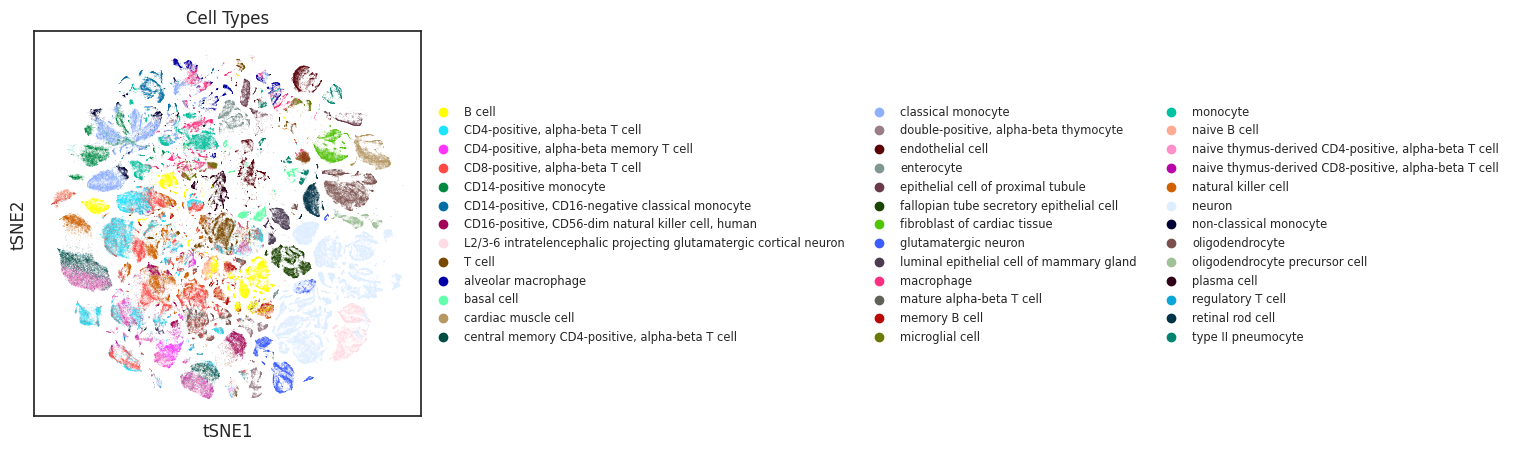

In [80]:
# Prepare for Visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams['figure.figsize'] = (5, 5)
# Create a subplot for the first plot and save it
ax1 = plt.subplot(111)
sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', title='Cell Types', ax=ax1, legend_loc='right margin', save="y_true.pdf")
plt.show()


In [82]:

# Create a binary comparison plot
plt.rcParams['figure.figsize'] = (5, 5)
# Create a subplot for the first plot and save it
ax1 = plt.subplot(111)
sc.pl.tsne(adata_plot, color='better_model', ax=ax1, show=False, title='Better Model', save="better_model.pdf")
plt.show()

